In [1]:
!pip install -q tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 3.9MB 41.8MB/s 
     |████████████████████████████████| 450kB 35.2MB/s 
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [2]:
!pip install -q tensorflow-quantum

     |████████████████████████████████| 3.9MB 3.0MB/s 
     |████████████████████████████████| 163kB 32.4MB/s 
     |████████████████████████████████| 1.4MB 22.4MB/s 
     |████████████████████████████████| 5.3MB 47.6MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 112kB 50.7MB/s 
     |████████████████████████████████| 1.2MB 50.8MB/s 


In [0]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [0]:
def generate_data(qubits):
    n_rounds = 20  
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(rng/np.pi)  #(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [81]:
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
for i in range(10):
  print('Input:', tfq.from_tensor(sample_points)[i], 'Output:', sample_labels[i])

Input: (0, 0): ───Rx(0.268π)─── Output: 0.26768050079094236
Input: (0, 1): ───Rx(-0.549π)─── Output: -0.5492798783751351
Input: (0, 2): ───Rx(-0.645π)─── Output: -0.6451812776101797
Input: (0, 3): ───Rx(0.481π)─── Output: 0.4811689537012046
Input: (0, 0): ───Rx(0.838π)─── Output: 0.8381908808878328
Input: (0, 1): ───Rx(-0.116π)─── Output: -0.11624863274825031
Input: (0, 2): ───Rx(0.626π)─── Output: 0.6255374095768969
Input: (0, 3): ───Rx(0.385π)─── Output: 0.3854754033807157
Input: (0, 0): ───Rx(-0.928π)─── Output: -0.9277202883864022
Input: (0, 1): ───Rx(-0.841π)─── Output: -0.8405069831929909


In [0]:
def cluster_state_circuit(bits):
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

In [0]:
#SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(2, 2)))

In [0]:
def one_qubit_unitary(bit, symbols):
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

def quantum_conv_circuit(bits, symbols):
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

def quantum_pool_circuit(source_bits, sink_bits, symbols):
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

In [0]:
#SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

In [0]:
#SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

In [0]:
#SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

In [0]:
#SVGCircuit(quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

In [60]:
'''test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))'''

"test_bits = cirq.GridQubit.rect(1, 8)\n\nSVGCircuit(\n    quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))"

In [0]:
def create_model_circuit(qubits):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')

    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]],symbols[57:63])
    return model_circuit

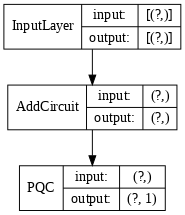

In [68]:
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [69]:
'''qubits=cirq.GridQubit.rect(1, 8)
circuit=create_model_circuit(qubits)
SVGCircuit(circuit)'''

'qubits=cirq.GridQubit.rect(1, 8)\ncircuit=create_model_circuit(qubits)\nSVGCircuit(circuit)'

In [77]:
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)

@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse) #, metrics=[custom_accuracy])

print(qcnn_model.summary())

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
add_circuit_8 (AddCircuit)   (None,)                   0         
_________________________________________________________________
pqc_3 (PQC)                  (None, 1)                 63        
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________
None
Train on 112 samples, validate on 48 samples
Epoch 1/25
112/112 [==============================] - 13s 117ms/sample - loss: 0.2880 - val_loss: 0.3058
Epoch 2/25
112/112 [==============================] - 13s 112ms/sample - loss: 0.2506 - val_loss: 0.3073
Epoch 3/25
112/112 [==============================] - 13s 113ms/sample - loss: 0.2407 - val_loss: 0.2915
Epoch 4/25
112/112 [========

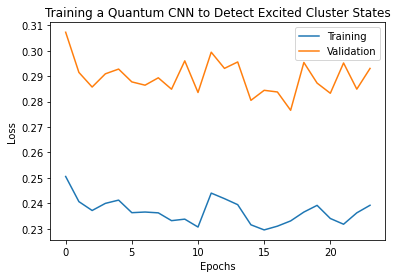

In [78]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

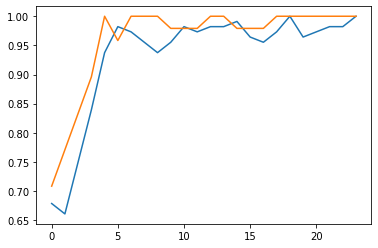

In [37]:
plt.plot(history.history['accuracy'][1:])
plt.plot(history.history['val_accuracy'][1:])